Basic import statements for the project

In [1]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
#glob is useful for working with filepaths
import glob
import math
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import re

1. Function for returning a list of filenames for the dance data

In [2]:
def get_file_list():
    #Saving all of the filepaths in data
    data = []
    for folder in glob.glob("../data/*"):
        if (folder[-3:] != '.md' and folder[-6:] != '.ipynb'):
            print(glob.glob(folder+'/*')[0])
            data.append(glob.glob(folder+'/*')[0])
    return data
        
files = get_file_list()

../data\1999_CharliXCX\05mAIVLkIWc2d1UBYZBCp8_date12_20_1999_CharliXCX_2.txt
../data\2On_Tinashe\3jVtllWS5CFFWLQng8sKsr_date2_7_2On_Tinashe_1.txt
../data\3Nights_DominicFike\1tNJrcVe6gwLEiZCtprs1u_date2_7_3Nights_DominicFike_4.txt
../data\Alaska_MaggieRogers\4HfLQJtVT1KiX1eVedDyTm_date2_7_Alaska_MaggieRogers_2.txt
../data\BadGuy_BillieEilish1\2Fxmhks0bxGSBdJ92vM42m_date12_20_BadGuy-BillieEilish_2.txt
../data\BadGuy_BillieEilish2\2Fxmhks0bxGSBdJ92vM42m_date12_23_BadGuy_BillieEilish_4.txt
../data\BadGuy_BillieEilish3\2Fxmhks0bxGSBdJ92vM42m_date1_31_BadGuy_BillieEilish_2.txt
../data\BallinFlossin_ChanceTheRapper\4pnIUqhf1AQMFrJPd4BbrT_date2_5_BallinFlossin_Chance_2.txt
../data\BaptizedInFire_KidCudi\6WSBZroxQaO3FYEpT2ACFH_date11_25_BaptisedinFire_KidCudi_2.txt
../data\BestSongEver_OneDirection\5T7ZFtCcOgkpjxcuaeZbw0_date2_7_BestSongEver_OneDirection_3.txt
../data\Body_LoudLuxury\21RzyxY3EFaxVy6K4RqaU9_date12_23_Body_LoudLuxury_2.txt
../data\BolaRebola_Tropkillaz\1OUPXna2MCgAt3VNmXJBtg_dat

The following cell defines the columns for our data.

In [3]:
data_columns = ['head_x', 'head_y', 'head_z',
               'neck_x', 'neck_y', 'neck_z',
               'spine_x', 'spine_y', 'spine_z',
               'hip_x', 'hip_y', 'hip_z',
               'shoulderl_x', 'shoulderl_y', 'shoulderl_z',
               'shoulderr_x', 'shoulderr_y', 'shoulderr_z',
               'elbowl_x', 'elbowl_y', 'elbowl_z',
               'elbowr_x', 'elbowr_y', 'elbowr_z',
               'wristl_x', 'wristl_y', 'wristl_z',
               'wristr_x', 'wristr_y', 'wristr_z',
               'handl_x', 'handl_y', 'handl_z',
               'handr_x', 'handr_y', 'handr_z',
               'handtipl_x', 'handtipl_y', 'handtipl_z',
               'handtipr_x', 'handtipr_y', 'handtipr_z',
               'hipl_x', 'hipl_y', 'hipl_z',
               'hipr_x', 'hipr_y', 'hipr_z',
               'kneel_x', 'kneel_y', 'kneel_z',
               'kneer_x', 'kneer_y', 'kneer_z',
               'anklel_x', 'anklel_y', 'anklel_z',
               'ankler_x', 'ankler_y', 'ankler_z',
               'footl_x', 'footl_y', 'footl_z',
               'footr_x', 'footr_y', 'footr_z']

In [4]:
def create_df(filename):
    array2d = []
    
    fp = open(filename, 'r')
    line = fp.readline()

    while line:
        frame = line.split()
        for i in range(len(frame)):
            frame[i] = float(frame[i])
        array2d.append(frame)
        line = fp.readline()

    df = pd.DataFrame(array2d, columns = data_columns)

    df["square_handtip_distance"] = (df['handtipl_x'] - df['handtipr_x'])**2 + (df['handtipl_y'] - df['handtipr_y'])**2 + (df['handtipl_z'] - df['handtipr_z'])**2

    non_zero = df[df["square_handtip_distance"] > 0]
    #currently is just an estimation, taking the first frame where the hand distance is less than 0.1
    clap_frame = non_zero[non_zero["square_handtip_distance"] < 0.1].index[0].copy()
    #add columns for time stamp and beat index
    df["time_stamp"] = 0
    df["beat_index"] = 0
    clap_onwards = df.iloc[clap_frame:]
    clap_onwards
    return clap_onwards, clap_frame

In [5]:
#setting up spotify credentials
def set_spotify():
    client_id = 'd0b2731526744c759fcf012a56ec5bd5'
    client_secret = '6e593cabd0e043da9041c5ef5825dec7'

    #Sets up authentication to use the Spotify API
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    #Creates a Spotipy session using the credentials
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp

sp = set_spotify()

In [6]:
#Search for song id and get beats object
#This will be automated in a playlist once that is set up
name = "Billie Eilish"
result = sp.search(name)
artist_uri = result['tracks']['items'][0]['artists'][0]["uri"]
sp_albums = sp.artist_albums(artist_uri, album_type='album')

tracks = sp.album_tracks(sp_albums['items'][0]['uri'])
id = tracks['items'][1]['id']

def get_beats(song_id, filename):
    analysis = sp.audio_analysis(id)
    features = sp.audio_features(id)
    #Starting beat will change depending on song
    eight_counts = int(re.search("\d+.txt", filename).group()[0])
    beat_count = eight_counts * 8 #not sure if this should be 4 or eight, we will know when we can visualize
    beats = analysis['beats'][beat_count:]
    return beats


In [7]:
def add_beats(dance, beats, clap_frame, filename):
    eight_counts = int(re.search("\d+.txt", filename).group()[0])
    beat_count = eight_counts * 8 #not sure if this should be 4 or eight, we will know when we can visualize
    #add time stamps to dataframe
    dance.loc[clap_frame, "time_stamp"] = beats[beat_count]["start"]

    current_beat = 0
    #for each row in the data frame...
    for index, row in dance.iterrows():
        time_stamp = beats[0]["start"] + 0.0666666666*(index-clap_frame)
        dance.loc[index, "time_stamp"] = time_stamp #set time stamp for each frame
        if current_beat < len(beats) - 1:
            if beats[current_beat + 1]["start"] < time_stamp:
                current_beat += 1
        dance.loc[index, "beat_index"] = current_beat #set beat index for each frame

    clap_to_end = dance[dance["time_stamp"] < beats[-1]["start"]].copy() #cut off frames where song ends

    return clap_to_end

In [8]:
def extrapolate_id(dataname):
    id_container = re.search("/\w{22}_", dataname).group()
    track_id = id_container[1:-1]
    return track_id

In [9]:
#parse_song takes in a filename and returns a dataframe of the dance data along with the beat intervals
def parse_song(filename):
    dance, clap_frame = create_df(filename)
    song_id = extrapolate_id(filename)
    beats = get_beats(song_id, filename)
    return add_beats(dance, beats, clap_frame, filename)

In [10]:
#segment_beats takes the result of parse song and returns a list of dataframes of individual beats to add to training set
def segment_beats(dance_data):
    #groups the dance data by their beat index
    groups = dance_data.groupby('beat_index')
    #initialize empty list to populate with song beats
    song_beats = []
    #iterate through each group and append to song_beats
    for name, group in groups:
        song_beats.append(group)
    return song_beats

In [11]:
def standardize_beats(filename):
    dance, clap_frame = create_df(filename)
    song_id = extrapolate_id(filename)
    beats = get_beats(song_id, filename)
    new_dance = add_beats(dance, beats, clap_frame, filename)
    curr_frame = clap_frame
    last_frame = new_dance.index[-1]
    times = []

    beats_df_start = pd.DataFrame(columns = ["start_time"] + data_columns)
    beats_df_mid = pd.DataFrame(columns = ["start_time"] + data_columns)
    beats_df_end = pd.DataFrame(columns = ["start_time"] + data_columns)


    #last beat is not included because it was excluded from the training set
    ##Start of Beat
    for beat in beats[:-1]:
        beat_data = [beat["start"]]
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat["start"]:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat["start"]:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat["start"] - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    #print(beat_pos)
                    beat_data.append(beat_pos)
                    #times += [beat["start"]]
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_start = beats_df_start.append(beat_line)

    curr_frame = clap_frame
    last_frame = new_dance.index[-1]

    #Middle of Beat
    for beat in beats[:-1]:
        beat_data = [beat["start"]]
        beat_mid = beat["start"] + beat["duration"] / 2
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat_mid:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat_mid:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat_mid - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    beat_data.append(beat_pos)
                    #times += [beat["start"]]
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_mid = beats_df_mid.append(beat_line)

    #End of Beat
    curr_frame = clap_frame
    last_frame = new_dance.index[-1]
    for beat in beats[:-2]:
        beat_data = [beat["start"]]
        beat_end = beat["start"] + beat["duration"]
        if (curr_frame < last_frame):
            while new_dance.loc[curr_frame + 1]["time_stamp"] < beat_end:
                curr_frame += 1
            if new_dance.loc[curr_frame + 1]["time_stamp"] > beat_end:
                #pinpointing position at beat
                #only for head_x right now, needs to be expanded to all points
                for point in data_columns:
                    f1 = new_dance.loc[curr_frame]
                    f2 = new_dance.loc[curr_frame + 1]
                    beat_pos = f1[point] + (beat_end - f1.time_stamp) * ((f2[point] - f1[point]) / (f2.time_stamp - f1.time_stamp))
                    beat_data.append(beat_pos)
                    #times += [beat["start"]]
        #creating a 1 row df for the beat
        beat_line = pd.DataFrame([beat_data], columns = ["start_time"] + data_columns)
        beats_df_end = beats_df_end.append(beat_line)

    beats_df_end = beats_df_end.append(new_dance.loc[last_frame][:66])
    beats_df_end.loc[last_frame, "start_time"] = beats[-2]["start"] #setting this manually since the data doesn't go this far

    mid_and_end = beats_df_mid.merge(beats_df_end, on="start_time", how="outer", suffixes=["", "_1"])
    standard_beats = beats_df_start.merge(mid_and_end, on="start_time", how="outer", suffixes=["_0", "_1/2"])
    return standard_beats

In [12]:
#setting up dataframe for 2nd neural network (synthesis)
def create_move_df(filename):
    song_id = extrapolate_id(filename)
    beats = get_beats(song_id, filename)
    features = sp.audio_features(song_id)
    song_features = features[0]
    analysis = sp.audio_analysis(song_id)
    sections = analysis['sections']
    curr_section_num = 0
    curr_section = sections[curr_section_num]

    #can add whatever features we feel like later, these ones felt like the most important for now
    cols = ["start_time", "duration", "section", "tempo", "danceability", "energy", "valence"]
    training_df_of_moves = pd.DataFrame(columns=cols)

    #add data to data frame (start, duration, section, tempo, features)
    for beat in beats:
        #sets section number for current beat
        if (curr_section["start"] + curr_section["duration"]) < beat["start"]:
            if curr_section_num + 1 != len(sections):
                curr_section_num = curr_section_num + 1
            curr_section = sections[curr_section_num]
        
        #creating data in row format for df
        beat_data = [beat["start"], beat["duration"], curr_section_num, curr_section["tempo"], song_features["danceability"], song_features["energy"], song_features["valence"]]
        beat_line = pd.DataFrame([beat_data], columns=cols)
        training_df_of_moves = training_df_of_moves.append(beat_line)
    
    #currently no moves, once first network outputs moves for each beat this is where we input it
    training_df_of_moves["move"] = None
    return training_df_of_moves

In [13]:
standardize_beats('../data/Wannabe_SpiceGirls/1Je1IMUlBXcx1Fz0WE7oPT_date12_23_Wannabe_SpiceGirls_0.txt')

,start_time,head_x_0,head_y_0,head_z_0,neck_x_0,neck_y_0,neck_z_0,spine_x_0,spine_y_0,spine_z_0,...,anklel_z_1,ankler_x_1,ankler_y_1,ankler_z_1,footl_x_1,footl_y_1,footl_z_1,footr_x_1,footr_y_1,footr_z_1
0,0.25371,0.298888,0.515556,3.005120,0.333421,0.394791,3.016600,0.316209,0.112909,3.037500,...,2.893405,0.388149,-0.781291,3.033900,0.162484,-0.794852,2.874600,0.419327,-0.827117,2.939772
1,0.69642,0.217616,0.506575,2.917944,0.215638,0.381377,2.938404,0.200090,0.118136,2.950729,...,2.914150,0.294944,-0.749018,3.023535,0.116232,-0.800627,2.793922,0.284744,-0.796933,2.955659
2,1.14002,0.158906,0.522393,2.949293,0.152941,0.390391,2.966208,0.141455,0.117844,2.979710,...,2.884442,0.213888,-0.717715,2.875268,0.113803,-0.774678,2.758125,0.168863,-0.756908,2.790280
3,1.58448,0.090785,0.528761,2.990522,0.074306,0.395229,2.996881,0.074811,0.122559,3.009419,...,3.033419,0.140924,-0.738353,2.863295,-0.149679,-0.783685,2.919149,0.107979,-0.782945,2.737020
4,2.02737,0.008130,0.526957,3.024919,-0.008236,0.392236,3.026049,-0.013990,0.122717,3.037196,...,3.021936,0.140114,-0.749420,2.878170,-0.215027,-0.774393,2.891750,0.141366,-0.784862,2.737782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,188.13562,-0.146904,0.483220,3.425240,-0.151742,0.354738,3.415292,-0.124339,0.111877,3.389891,...,3.261459,-0.167096,-0.679908,3.370407,-0.181969,-0.797284,3.138472,-0.295054,-0.558425,3.330794
415,188.63329,-0.111724,0.495767,3.474683,-0.092984,0.359231,3.478986,-0.094274,0.113763,3.412146,...,3.316041,-0.025766,-0.700257,3.204950,-0.127683,-0.804977,3.242850,-0.025776,-0.783013,3.176564
416,189.12866,-0.080505,0.472065,3.498199,-0.071489,0.341111,3.510092,-0.071904,0.089336,3.438848,...,3.351840,-0.031907,-0.702438,2.776577,-0.089252,-0.808519,3.216637,-0.066154,-0.769866,2.632748
417,189.62387,-0.042732,0.513128,3.500690,-0.002625,0.381488,3.474620,-0.018799,0.110718,3.438550,...,3.345681,0.086240,-0.753011,3.213580,-0.099900,-0.821185,3.223790,0.011058,-0.787345,3.057642


In [14]:
create_move_df('../data/Wannabe_SpiceGirls/1Je1IMUlBXcx1Fz0WE7oPT_date12_23_Wannabe_SpiceGirls_0.txt')

,start_time,duration,section,tempo,danceability,energy,valence,move
0,0.25371,0.44271,0,101.684,0.768,0.864,0.891,None
0,0.69642,0.44360,0,101.684,0.768,0.864,0.891,None
0,1.14002,0.44446,0,101.684,0.768,0.864,0.891,None
0,1.58448,0.44289,0,101.684,0.768,0.864,0.891,None
0,2.02737,0.44366,0,101.684,0.768,0.864,0.891,None
...,...,...,...,...,...,...,...,...
0,188.63329,0.49537,9,108.936,0.768,0.864,0.891,None
0,189.12866,0.49521,9,108.936,0.768,0.864,0.891,None
0,189.62387,0.48176,9,108.936,0.768,0.864,0.891,None
0,190.10562,0.47012,9,108.936,0.768,0.864,0.891,None


In [16]:
#defining columns for beat structure
start = [name + '_0' for name in data_columns]
mid = [name + '_1/2' for name in data_columns]
end = [name + '_1' for name in data_columns]
#cols should be altered as we do more feature engineering, perhaps adding more snapshots or other data (velocity and such)
cols = ["start_time"] + start + mid + end
training_df_of_beats = pd.DataFrame(columns=cols)


for file in files[:10]:
    file = file.replace('\\', '/')
    print(file)
    beats = standardize_beats(file)
    training_df_of_beats = pd.concat([training_df_of_beats, beats])
    
training_df_of_beats

../data/1999_CharliXCX/05mAIVLkIWc2d1UBYZBCp8_date12_20_1999_CharliXCX_2.txt
../data/2On_Tinashe/3jVtllWS5CFFWLQng8sKsr_date2_7_2On_Tinashe_1.txt
../data/3Nights_DominicFike/1tNJrcVe6gwLEiZCtprs1u_date2_7_3Nights_DominicFike_4.txt
../data/Alaska_MaggieRogers/4HfLQJtVT1KiX1eVedDyTm_date2_7_Alaska_MaggieRogers_2.txt
../data/BadGuy_BillieEilish1/2Fxmhks0bxGSBdJ92vM42m_date12_20_BadGuy-BillieEilish_2.txt
../data/BadGuy_BillieEilish2/2Fxmhks0bxGSBdJ92vM42m_date12_23_BadGuy_BillieEilish_4.txt
../data/BadGuy_BillieEilish3/2Fxmhks0bxGSBdJ92vM42m_date1_31_BadGuy_BillieEilish_2.txt
../data/BallinFlossin_ChanceTheRapper/4pnIUqhf1AQMFrJPd4BbrT_date2_5_BallinFlossin_Chance_2.txt
../data/BaptizedInFire_KidCudi/6WSBZroxQaO3FYEpT2ACFH_date11_25_BaptisedinFire_KidCudi_2.txt
../data/BestSongEver_OneDirection/5T7ZFtCcOgkpjxcuaeZbw0_date2_7_BestSongEver_OneDirection_3.txt


,start_time,head_x_0,head_y_0,head_z_0,neck_x_0,neck_y_0,neck_z_0,spine_x_0,spine_y_0,spine_z_0,...,anklel_z_1,ankler_x_1,ankler_y_1,ankler_z_1,footl_x_1,footl_y_1,footl_z_1,footr_x_1,footr_y_1,footr_z_1
0,7.35531,1.521880,0.737255,2.632900,1.546000,0.649987,2.574450,1.527390,0.286615,2.567520,...,2.563863,1.516862,-0.515009,2.535339,1.520953,-0.488528,2.518801,1.462404,-0.544779,2.512580
1,7.80114,1.440132,0.771473,2.587130,1.455931,0.660505,2.575710,1.445568,0.375803,2.595650,...,2.556038,1.482460,-0.503898,2.501659,1.484687,-0.531013,2.466010,1.468748,-0.538441,2.494170
2,8.24776,1.383971,0.789110,2.664735,1.395598,0.668803,2.660981,1.395869,0.406049,2.656737,...,2.854452,1.538460,-0.443798,2.468416,1.200171,-0.738563,2.842028,1.421096,-0.469450,2.389369
3,8.69396,1.284920,0.785244,2.759107,1.309550,0.664615,2.739284,1.299140,0.388593,2.752484,...,2.824958,1.505567,-0.487614,2.513875,1.178718,-0.780451,2.795981,1.427899,-0.528104,2.429940
4,9.13935,1.217627,0.805843,2.817570,1.249670,0.677239,2.799180,1.243999,0.397416,2.806310,...,2.814484,1.424435,-0.563872,2.544266,1.217323,-0.775140,2.795739,1.409536,-0.625243,2.484904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,188.13562,0.551873,0.526526,4.568181,0.569634,0.419416,4.493638,0.579727,0.073635,4.429239,...,4.049416,0.616195,-1.098460,4.038250,0.520185,-1.132730,3.975250,0.541092,-1.107441,3.951465
391,188.63329,0.639984,0.312605,4.520310,0.654484,0.215555,4.428870,0.648852,-0.122261,4.367090,...,3.914526,0.746827,-1.191490,3.870850,0.574366,-1.166540,3.841220,0.734617,-1.140209,3.835265
392,189.12866,0.673916,0.323697,4.554185,0.680737,0.211469,4.483252,0.672665,-0.116659,4.427819,...,4.239810,0.731300,-1.072155,3.946866,0.664285,-1.150470,4.075417,0.674679,-1.091620,3.851510
393,189.62387,0.701325,0.148428,4.568390,0.701068,0.015120,4.520550,0.706236,-0.273112,4.496060,...,4.599392,0.728274,-1.045580,3.979080,0.694357,-1.164460,4.404390,0.643236,-1.088197,3.865588


# MACHINE LEARNING

In [17]:
from sklearn.cluster import KMeans

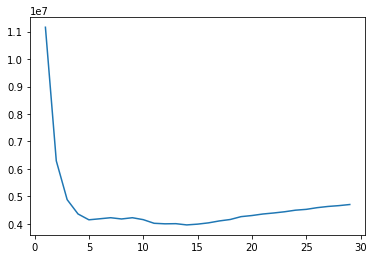

In [20]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(training_df_of_beats)
    wcss.append(kmeans.inertia_ * i)
plt.plot(range(1, 30), wcss)
plt.show()

In [26]:
kmeans = KMeans(n_clusters = wcss.index(min(wcss)), init = 'k-means++', random_state = 42)
kmeans.fit(training_df_of_beats)
all_predictions = kmeans.predict(training_df_of_beats)

In [33]:
pd.Series(all_predictions).value_counts()

9     455
10    425
6     414
11    413
0     412
8     391
3     389
4     383
1     377
5     130
2      88
7      86
12     35
dtype: int64